In [157]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph
import torch

In [158]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



In [159]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [160]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


Forward propagation en el primer perceptron

In [161]:
#Inputs
x1 = torch.Tensor([2.5]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([3.5]).double()                ; x2.requires_grad = True
x3 = torch.Tensor([-0.5]).double()               ; x3.requires_grad = True

#Pesos
w11 = torch.Tensor([0.1]).double()               ; w11.requires_grad = True
w12 = torch.Tensor([-0.2]).double()              ; w12.requires_grad = True
w13 = torch.Tensor([0.3]).double()               ; w13.requires_grad = True

#Bias
b11 = torch.Tensor([0.01]).double()              ; b11.requires_grad = True

#Conbinacion lineal
n1 = x1*w11 + x2*w12 + x3*w13 + b11

#Funcion de activacion
h11 = torch.relu(n1)

print(h11.data.item())
#o.backward()
print('---')


#print('x2', x2.grad.item())
#print('w2', w2.grad.item())
#print('x1', x1.grad.item())
#print('w1', w1.grad.item())

0.0
---


Forward propagation en el segundo perceptron

In [162]:
#Inputs
x1 = torch.Tensor([2.5]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([3.5]).double()                ; x2.requires_grad = True
x3 = torch.Tensor([-0.5]).double()               ; x3.requires_grad = True

#Pesos
w21 = torch.Tensor([0.4]).double()               ; w21.requires_grad = True
w22 = torch.Tensor([0.5]).double()               ; w21.requires_grad = True
w23 = torch.Tensor([-0.6]).double()               ; w21.requires_grad = True

#Bias
b12 = torch.Tensor([0.02]).double()              ; b12.requires_grad = True

#Conbinacion lineal
n2 = x1*w21 + x2*w22 + x3*w23 + b12

#Funcion de activacion
h12 = torch.relu(n2)

print(h12.data.item())
#o.backward()
print('---')

3.0700000263750553
---


Forward propagation en el tercer perceptron

In [163]:
#Inputs
x1 = torch.Tensor([2.5]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([3.5]).double()                ; x2.requires_grad = True
x3 = torch.Tensor([-0.5]).double()               ; x3.requires_grad = True

#Pesos
w31 = torch.Tensor([-0.7]).double()               ; w31.requires_grad = True
w32 = torch.Tensor([0.8]).double()               ; w31.requires_grad = True
w33 = torch.Tensor([-0.9]).double()               ; w31.requires_grad = True

#Bias
b13 = torch.Tensor([0.03]).double()              ; b13.requires_grad = True

#Conbinacion lineal
n3 = x1*w31 + x2*w32 + x3*w33 + b13

#Funcion de activacion
h13 = torch.relu(n3)

print(h13.data.item())
#o.backward()
print('---')

1.5300000589340925
---


Forward propagation en el cuarto perceptron

In [164]:
#Inputs
x1 = torch.Tensor([2.5]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([3.5]).double()                ; x2.requires_grad = True
x3 = torch.Tensor([-0.5]).double()               ; x3.requires_grad = True

#Pesos
w41 = torch.Tensor([0.2]).double()               ; w41.requires_grad = True
w42 = torch.Tensor([-0.4]).double()               ; w41.requires_grad = True
w43 = torch.Tensor([0.6]).double()               ; w41.requires_grad = True

#Bias
b14 = torch.Tensor([0.04]).double()              ; b14.requires_grad = True

#Conbinacion lineal
n4 = x1*w41 + x2*w42 + x3*w43 + b14

#Funcion de activacion
h14 = torch.relu(n4)

print(h14.data.item())
#o.backward()
print('---')

0.0
---


In [165]:
# Inputs de la hidden layer
h11.data.item(), h12.data.item(), h13.data.item(), h14.data.item()

(0.0, 3.0700000263750553, 1.5300000589340925, 0.0)

Forward propagation en el primer perceptron

In [166]:
#Inputs  h11, h12, h13, h14

#Pesos
w11 = torch.Tensor([0.2]).double()               ; w11.requires_grad = True
w12 = torch.Tensor([0.1]).double()              ; w12.requires_grad = True
w13 = torch.Tensor([-0.3]).double()               ; w13.requires_grad = True
w14 = torch.Tensor([0.4]).double()               ; w14.requires_grad = True

#Bias
b21 = torch.Tensor([0.05]).double()              ; b21.requires_grad = True

#Conbinacion lineal
n1 = h11*w11 + h12*w12 + h13*w13 + h14*w14 + b21

#Funcion de activacion
h21 = torch.relu(n1)

print(h21.data.item())
#o.backward()
print('---')

0.0
---


Forward propagation en el segundo perceptron

In [167]:
#Inputs  h11, h12, h13, h14

#Pesos
w21 = torch.Tensor([-0.5]).double()             ; w21.requires_grad = True
w22 = torch.Tensor([0.6]).double()              ; w22.requires_grad = True
w23 = torch.Tensor([-0.2]).double()             ; w23.requires_grad = True
w24 = torch.Tensor([0.3]).double()              ; w24.requires_grad = True

#Bias
b22 = torch.Tensor([0.06]).double()             ; b22.requires_grad = True

#Conbinacion lineal
n1 = h11*w21 + h12*w22 + h13*w23 + h14*w24 + b22

#Funcion de activacion
h22 = torch.relu(n1)

print(h22.data.item())
#o.backward()
print('---')

1.5960000713318592
---


Forward propagation en el tercero perceptron

In [168]:
#Inputs  h11, h12, h13, h14

#Pesos
w31 = torch.Tensor([0.7]).double()               ; w31.requires_grad = True
w32 = torch.Tensor([-0.8]).double()              ; w32.requires_grad = True
w33 = torch.Tensor([0.5]).double()               ; w33.requires_grad = True
w34 = torch.Tensor([-0.4]).double()              ; w34.requires_grad = True

#Bias
b23 = torch.Tensor([0.07]).double()              ; b23.requires_grad = True

#Conbinacion lineal
n1 = h11*w31 + h12*w32 + h13*w33 + h14*w34 + b23

#Funcion de activacion
h23 = torch.relu(n1)

print(h23.data.item())
#o.backward()
print('---')

0.0
---


Forward propagation en el cuarto perceptron

In [169]:
#Inputs  h11, h12, h13, h14

#Pesos
w41 = torch.Tensor([-0.1]).double()               ; w41.requires_grad = True
w42 = torch.Tensor([0.3]).double()              ; w42.requires_grad = True
w43 = torch.Tensor([0.2]).double()               ; w43.requires_grad = True
w44 = torch.Tensor([-0.6]).double()              ; w44.requires_grad = True

#Bias
b24 = torch.Tensor([0.08]).double()              ; b24.requires_grad = True

#Conbinacion lineal
n1 = h11*w41 + h12*w42 + h13*w43 + h14*w44 + b24

#Funcion de activacion
h24 = torch.relu(n1)

print(h24.data.item())
#o.backward()
print('---')

1.3070000590682036
---


In [170]:
# Inputs de la output layer
h21.data.item(), h22.data.item(), h23.data.item(), h24.data.item()

(0.0, 1.5960000713318592, 0.0, 1.3070000590682036)

Forward propagation en el ultimo perceptron

In [171]:
#Inputs  h21, h22, h23, h24

#Pesos
w51 = torch.Tensor([0.2]).double()               ; w51.requires_grad = True
w52 = torch.Tensor([-0.3]).double()              ; w52.requires_grad = True
w53 = torch.Tensor([0.4]).double()               ; w53.requires_grad = True
w54 = torch.Tensor([-0.5]).double()              ; w54.requires_grad = True

#Bias
b31 = torch.Tensor([0.1]).double()              ; b31.requires_grad = True

#Conbinacion lineal
Y = h21*w51 + h22*w52 + h23*w53 + h24*w54 + b31

#Funcion de activacion
h31 = torch.relu(n1)

print(Y.data.item())
#Y.backward()
print('---')

-1.0323000684693469
---


In [172]:
Y.data.item()

-1.0323000684693469

Backward propagation

In [173]:
n = MLP(3, [4, 4, 1])

In [174]:
xs = ([
  [2.5, 3.5, -0.5],
  [4.0, -1.0, 0.5],
  [0.5, 1.5, 1.0],
  [3.0, 2.0, -1.5],
])
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [175]:
Ypred = [n(x) for x in xs]


In [176]:
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data, ypred)

0 7.281370461036747 [Value(data=-0.8876460818254962), Value(data=-0.9082587240800459), Value(data=-0.885125147025828), Value(data=-0.9226414219121412)]
1 6.366077461831623 [Value(data=-0.7491882027855048), Value(data=-0.8221840735966924), Value(data=-0.8076689698048941), Value(data=-0.7993911092947695)]
2 2.228023529318058 [Value(data=0.13388416734525616), Value(data=-0.37039822259778155), Value(data=-0.45451446635860304), Value(data=0.11461080409643251)]
3 1.7218690058375303 [Value(data=0.7793467632093729), Value(data=-0.004146774918564452), Value(data=-0.20518522847974927), Value(data=0.7770045112575926)]
4 2.387452085386223 [Value(data=-0.049140579631142996), Value(data=-0.7706735661169458), Value(data=-0.8959483929051995), Value(data=-0.10604646346386483)]
5 5.173575077917828 [Value(data=0.9442671751427605), Value(data=0.4256674569123079), Value(data=0.7705545148628471), Value(data=0.9445207935236809)]
6 0.6146858977837771 [Value(data=0.6732015195989414), Value(data=-0.790933194810

In [177]:
loss.backward()

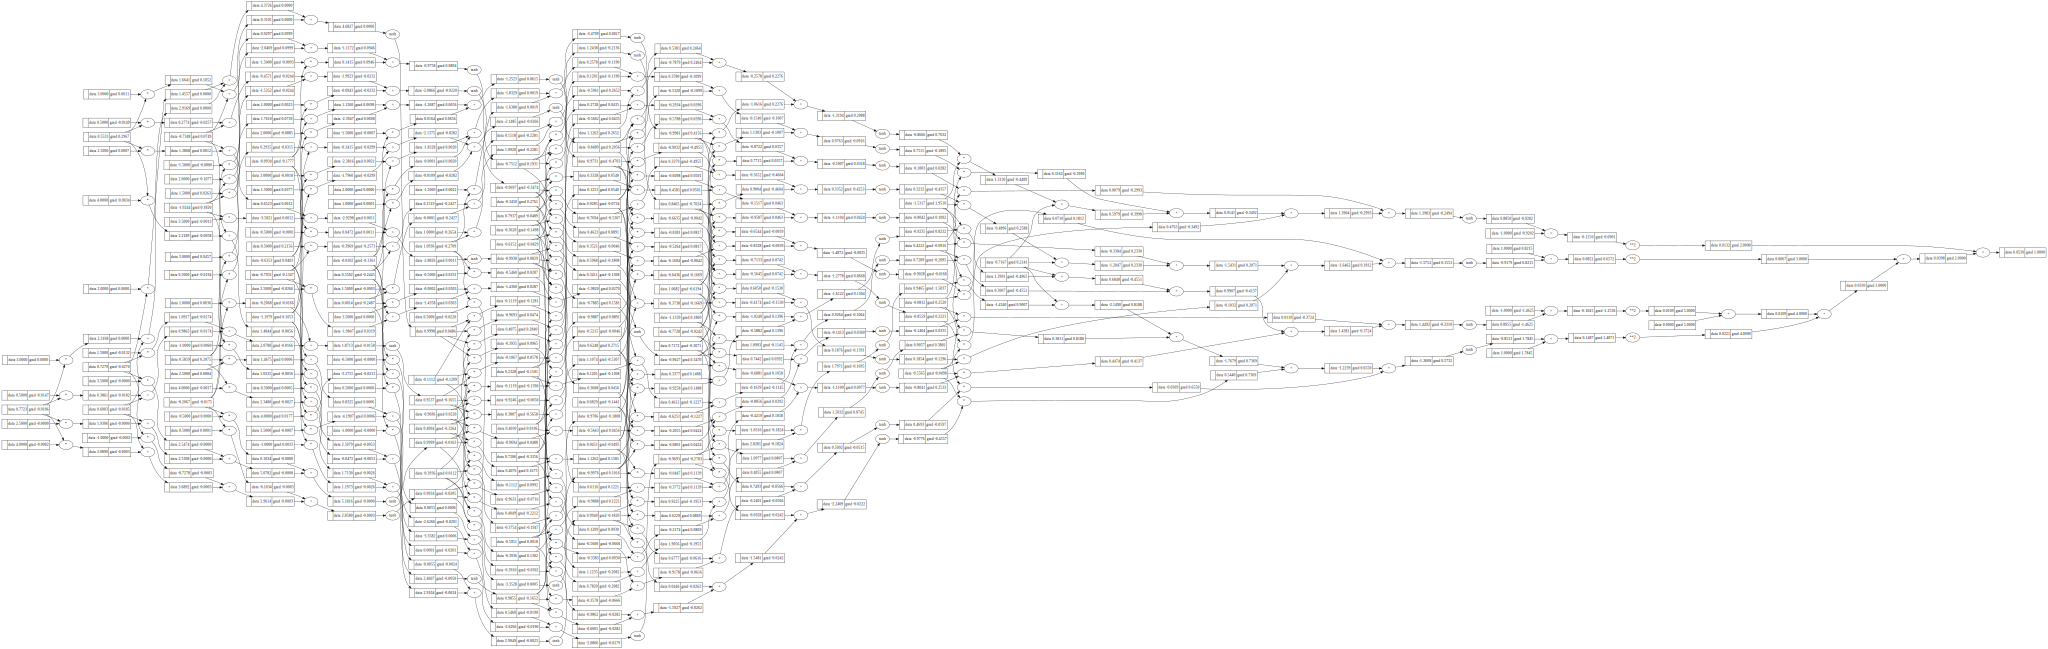

In [178]:
draw_dot(loss)